In [1]:
# 전체 코드 예시: Pandas DataFrame에 저장된 데이터를 사용하여 GAN을 학습시키는 예제
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
import time

import os
import random
import warnings
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 동일 결과 재생성을 위한 랜덤성 고정
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Using device:', device)

Using device: cuda


### 전체 원재료코드(JRCODE) 및 공정종류(PUTGB) 인코딩 테이블 및 nast 딕셔너리 생성
### 데이터 필터링 및 저장

In [3]:
combined_df = pd.read_csv(f'./final_dataset/combined_pps_data_fin.csv')

In [4]:
tmp_df = combined_df.copy()
tmp_df = tmp_df.fillna(np.nan)

# 원재료 코드 리스트 생성
JRCODE_ls = []
jrcode_col_ls = [col for col in tmp_df.columns if 'JRCODE' in col]
for jrcode_col in jrcode_col_ls:
    JRCODE_ls += tmp_df[jrcode_col].unique().tolist()
    JRCODE_ls = list(set(JRCODE_ls))
    JRCODE_ls = [x for x in JRCODE_ls if str(x) != 'nan']

# 이상 원재료코드 리스트 생성
rm_jrcode_ls = [jr for jr in JRCODE_ls if 'C1' in jr]

for rm_jr in rm_jrcode_ls:
    JRCODE_ls.remove(rm_jr)

# 원재료 코드 테이블 생성
JRCODE_df = pd.DataFrame({'JRCODE':JRCODE_ls}).sort_values('JRCODE').reset_index(drop=True)
JRCODE_df['JR_ID'] = JRCODE_df.index
JRCODE_df = JRCODE_df[['JRCODE','JR_ID']]

# 공정 타입 테이블 생성 (1-6)
PUTGB_df = pd.DataFrame({'PUTGB':['P','CH','CB','OA','OB','F']}).reset_index(drop=True)
PUTGB_df['PUTGB_ID'] = PUTGB_df.index + 1 # (1-6)
PUTGB_df.columns = ['PUTGB_ID','PUTGB']

display(f'전체 원재료코드 수 : {len(JRCODE_df)}, 공정종류 수 : {len(PUTGB_df)}')

# 원재료 코드 dictionary 생성
JRCODE_dict = {}
for idx, row in JRCODE_df.iterrows():
    JRCODE_dict[row['JRCODE']] = row['JR_ID']

# 공정 타입 dictionary 생성
PUTGB_dict = {}
for idx, row in PUTGB_df.iterrows():
    PUTGB_dict[row['PUTGB']] = row['PUTGB_ID']

# nan을 마지막으로 추가
JRCODE_dict['0'] = len(JRCODE_dict)+1
PUTGB_dict['0'] = len(PUTGB_dict)+1

display(f'NAN포함!! JRCODE 딕셔너리 길이: {len(JRCODE_dict)}, PUTGB 딕셔너리 길이: {len(PUTGB_dict)}')

'전체 원재료코드 수 : 833, 공정종류 수 : 6'

'NAN포함!! JRCODE 딕셔너리 길이: 834, PUTGB 딕셔너리 길이: 7'

In [5]:
filtered_idx_ls = []
for rm_jrcode in rm_jrcode_ls:
    for col in jrcode_col_ls:
        tmp_tmp_df = tmp_df[~(tmp_df[col].isna())]
        filtered_idx_ls += tmp_tmp_df[(tmp_tmp_df[col].str.contains(rm_jrcode))].index.tolist()

        filtered_idx_ls = list(set(filtered_idx_ls))

tmp_df = tmp_df.iloc[[idx for idx in tmp_df.index if idx not in filtered_idx_ls]].reset_index(drop=True)
tmp_df = tmp_df.fillna(0)
tmp_df

,ID,TYPE,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME,HS_VAL,SG_VAL,TS_VAL,EB_VAL
0,0000QY001_T010,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE017A,EE011G,EE023A,CB003A,CB001C,CB011B,CD023B,CD013A,CD011A,CD005A,FF005A,NN031A,OP004A,OP005A,0,0,0,0,0,0,0,0,0,0,0,9.523810,27.619048,41.428571,2.380952,0.47619,0.47619,0.47619,0.714286,0.714286,0.714286,100.000,54.285714,38.095238,19.047619,0.000,0.000,0.000,0.000000,0.000,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,74.0,1.100,151.0,245.0
1,0504PA001_T001,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
2,0504PA001_T002,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100.000000,10.000000,1.000000,2.000000,10.00000,15.00000,15.00000,0.000000,0.000000,0.000000,

In [6]:
# Discriminator 모델 정의
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),            
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(8, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)

# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Linear(128, output_size),
            # nn.Tanh(),
        )
    
    def forward(self, x):
        return self.model(x)
    
# # Generator 모델 정의
# class Generator(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_size, 128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             # nn.BatchNorm1d(256),
#             nn.Linear(256, output_size),
#             # nn.Tanh(),
#         )
    
#     def forward(self, x):
#         return self.model(x)

In [7]:
batch_size = 64
lr = 0.001
num_epochs = 100
show_step = 10
loss_function = nn.BCELoss()

# 대상
trg_yCols = ['HS_VAL','SG_VAL','TS_VAL','EB_VAL']

data_df = tmp_df.copy()
for i in range(1, 26):
    data_df['JRCODE'+str(i)] = data_df['JRCODE'+str(i)].apply(lambda x: int(JRCODE_dict[str(x)]))
    data_df['PHR'+str(i)].fillna(0, inplace=True)

data_df = data_df.drop(['ID','TYPE']+trg_yCols, axis=1)
data_df = data_df.iloc[:-(len(data_df) % batch_size)]

# DataFrame을 PyTorch Tensor로 변환
data = torch.tensor(data_df.values, dtype=torch.float32)

# DataLoader 설정
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델, 옵티마이저, 손실 함수 설정
input_size = len(data_df.columns)  # 입력 feature의 개수
latent_size = 100  # 잠재 공간의 크기
output_size = len(data_df.columns)  # 출력 feature의 개수
discriminator = Discriminator(input_size)
generator = Generator(latent_size, output_size)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

p_d_real_trace = []
p_d_gen_trace = []
p_g_gen_trace = []

# 학습 시작
stTime = time.time()

gen_loss_trace = []
dis_loss_trace = []

for epoch in range(num_epochs):    
    gen_loss = 0
    dis_loss = 0

    for n, (real_samples,) in enumerate(dataloader):
        # batch_size = real_samples.size(0)

        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        output_real = discriminator(real_samples)

        generated_samples = generator(torch.randn((batch_size, latent_size)))
        generated_samples_labels = torch.zeros((batch_size, 1))
        output_gen = discriminator(generated_samples)

        # Training the discriminator
        discriminator.zero_grad()
        loss_real = loss_function(output_real, real_samples_labels)
        loss_gen = loss_function(output_gen, generated_samples_labels)
        d_loss = loss_real + loss_gen

        d_loss.backward()
        d_optimizer.step()

        dis_loss += d_loss.item()/batch_size

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, latent_size))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        g_loss = loss_function(output_discriminator_generated, real_samples_labels)

        g_loss.backward()
        g_optimizer.step()

        gen_loss += g_loss.item()/batch_size

        p_d_real_trace.append(loss_real.item())
        p_d_gen_trace.append(loss_gen.item())
        p_g_gen_trace.append(g_loss.item())

    # Show loss
    if epoch % show_step == 0:
        print(f"Epoch: {epoch:3.0f} Loss D.: {dis_loss:.5f}, Loss G.: {gen_loss:.5f}, time: {(time.time() - stTime):.3f}s")
        stTime = time.time()

    gen_loss_trace.append(gen_loss)
    dis_loss_trace.append(dis_loss)

Epoch:   0 Loss D.: 4.17654, Loss G.: 7.11490, time: 6.082s
Epoch:  10 Loss D.: 3.62600, Loss G.: 16.07714, time: 43.859s
Epoch:  20 Loss D.: 4.37481, Loss G.: 13.82827, time: 41.068s
Epoch:  30 Loss D.: 6.65591, Loss G.: 9.76902, time: 45.021s
Epoch:  40 Loss D.: 7.00159, Loss G.: 9.35865, time: 59.778s
Epoch:  50 Loss D.: 6.82768, Loss G.: 9.47879, time: 58.504s
Epoch:  60 Loss D.: 7.75304, Loss G.: 7.69819, time: 58.147s
Epoch:  70 Loss D.: 7.33397, Loss G.: 8.69504, time: 62.139s
Epoch:  80 Loss D.: 7.11230, Loss G.: 10.04094, time: 50.113s
Epoch:  90 Loss D.: 7.41098, Loss G.: 8.55675, time: 41.947s


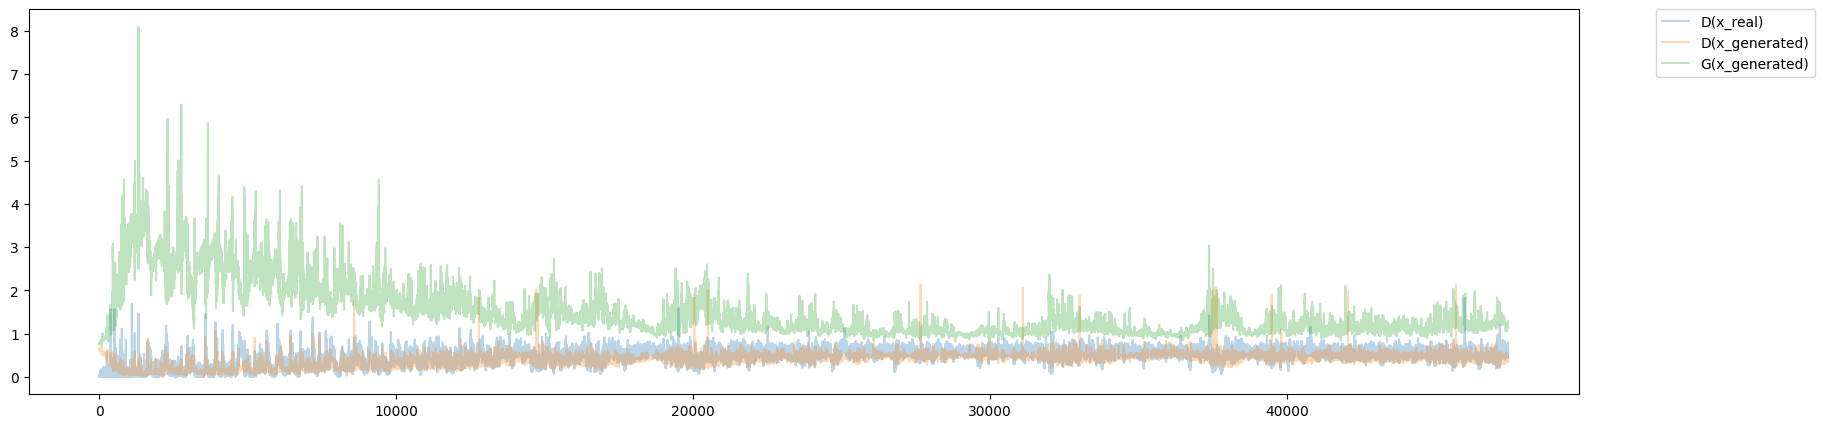

In [8]:
from matplotlib import pyplot as plt

sIdx = 50
plt.figure(figsize=(20,5))
plt.plot(p_d_real_trace[sIdx:], label='D(x_real)', alpha=0.3)
plt.plot(p_d_gen_trace[sIdx:], label='D(x_generated)', alpha=0.3)
plt.plot(p_g_gen_trace[sIdx:], label='G(x_generated)', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

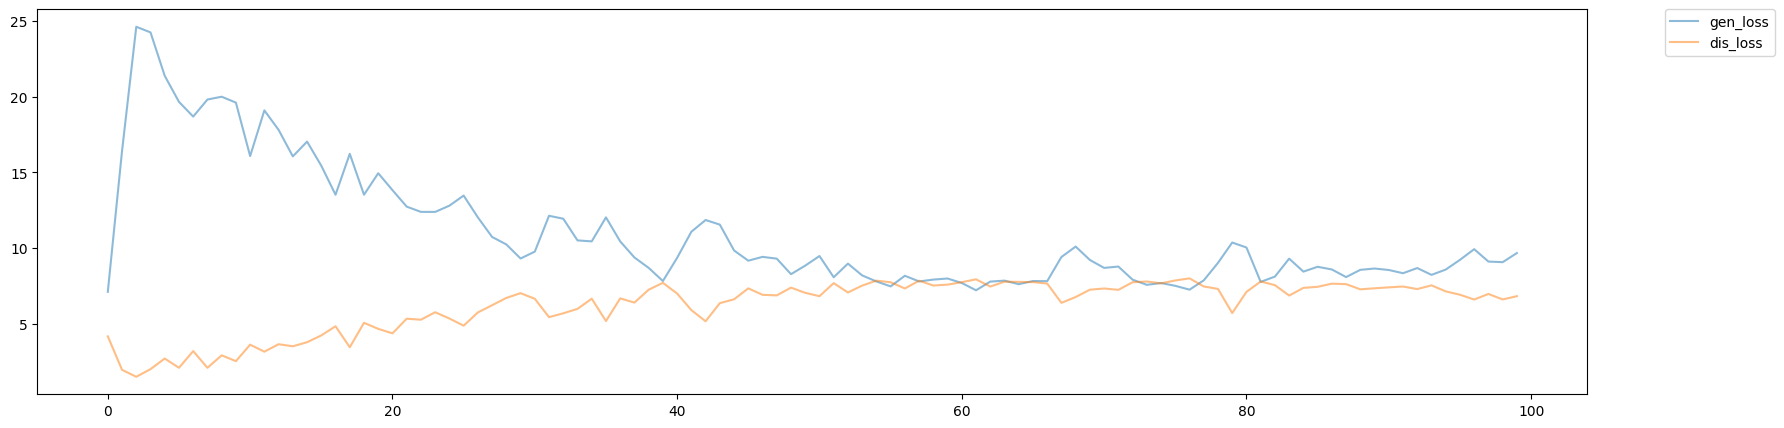

In [9]:
from matplotlib import pyplot as plt

sIdx = 0
plt.figure(figsize=(20,5))
plt.plot(gen_loss_trace[sIdx:], label='gen_loss', alpha=0.5)
plt.plot(dis_loss_trace[sIdx:], label='dis_loss', alpha=0.5)
# plt.ylim(0,2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [10]:
n_samples = len(data_df)
gen_samples = generator(torch.randn(n_samples, latent_size))
gen_df = pd.DataFrame(gen_samples.detach(), columns=data_df.columns)
# display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
display('ori:',data_df.iloc[:,:].describe(),'gen:',gen_df.iloc[:,:].describe())

'ori:'

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
count,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.00000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.0,30400.0,30400.0,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.00000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000
mean,130.928865,134.580663,133.823997,152.698750,147.965663,149.209046,112.240905,110.021657,100.868371,204.155327,280.446755,401.917468,541.182488,679.145269,764.294737,633.633125,597.704474,428.342007,313.670822,108.228421,22.965658,17.078980,0.446941,81.666840,61.102874,59.328998,65.734827,78.884533,90.174902,103.619040,113.582105,117.527126,114.658315,98.206364,73.420695,54.010817,42.473814,38.441644,34.600008,31.623299,22.955812,14.568849,8.309089,4.226467,1.671102,0.441141,63.835230,17.501098,25.526897,25.759481,26.467501,20.694707,23.776984,22.2641

'gen:'

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
count,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000,30400.000000
mean,-0.218480,16.063805,35.127525,49.811974,73.548866,42.843132,56.259655,46.100418,20.490400,70.153732,8.986494,48.826332,13.259544,9.262727,-23.319057,18.326136,24.220261,11.236462,12.248088,1.106409,17.889427,8.282258,9.032877,35.151363,67.391563,27.963188,89.057579,96.816559,128.453262,128.569077,96.987747,100.031876,134.879288,77.476349,83.094490,31.456135,23.057629,25.399010,21.111980,13.024159,26.135187,36.950104,21.972275,-1.563584,-2.542716,-25.811863,116.686592,29.436966,15.625322,19.654148,7.057397,33.465149,15.493557,9.108981

In [46]:
# batch_size = 64
# lr = 0.001
# num_epochs = 20
# show_step = 2
# loss_function = nn.BCELoss()

# # 모델 인덱스
# model_index = '1_1'

# # 대상
# yCols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

# for yCol in yCols[:1]:
#     data_df = pd.read_csv(f'./dataset/data_{yCol}_jrcode_fin.csv')
#     for i in range(1, 21):
#         data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].apply(lambda x: int(JRCODE_dict[x]))
#         # data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].where(data_df['jrcode'+str(i)] == len(JRCODE_dict), np.nan)
#         data_df['phr'+str(i)].fillna(0, inplace=True)

#     data_df['mix_ds_cd'] = data_df['mix_ds_cd'].apply(lambda x: int(MIXDSCD_dict[x]))
#     # data_df['mix_ds_cd'] = data_df['mix_ds_cd'].where(data_df['mix_ds_cd'] == len(MIXDSCD_dict), np.nan)

#     data_df = data_df.drop(['lab_pk',yCol], axis=1)
#     data_df = data_df.iloc[:-(len(data_df) % batch_size)]

#     # DataFrame을 PyTorch Tensor로 변환
#     data = torch.tensor(data_df.values, dtype=torch.float32)

#     # DataLoader 설정
#     dataset = TensorDataset(data)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     # 모델, 옵티마이저, 손실 함수 설정
#     input_size = len(data_df.columns)  # 입력 feature의 개수
#     latent_size = 100  # 잠재 공간의 크기
#     output_size = len(data_df.columns)  # 출력 feature의 개수
#     discriminator = Discriminator(input_size)
#     generator = Generator(latent_size, output_size)
#     d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
#     g_optimizer = optim.Adam(generator.parameters(), lr=lr)

#     p_d_real_trace = []
#     p_d_gen_trace = []
#     p_g_gen_trace = []

#     # 학습 시작
#     for epoch in range(num_epochs):
#         for n, (real_samples,) in enumerate(dataloader):
#             # batch_size = real_samples.size(0)

#             # Data for training the discriminator
#             real_samples_labels = torch.ones((batch_size, 1))
#             output_real = discriminator(real_samples)

#             generated_samples = generator(torch.randn((batch_size, latent_size)))
#             generated_samples_labels = torch.zeros((batch_size, 1))
#             output_gen = discriminator(generated_samples)

#             # Training the discriminator
#             discriminator.zero_grad()
#             loss_real = loss_function(output_real, real_samples_labels)
#             loss_gen = loss_function(output_gen, generated_samples_labels)
#             loss_discriminator = loss_real + loss_gen
#             loss_discriminator.backward()
#             d_optimizer.step()

#             # Data for training the generator
#             latent_space_samples = torch.randn((batch_size, latent_size))

#             # Training the generator
#             generator.zero_grad()
#             generated_samples = generator(latent_space_samples)
#             output_discriminator_generated = discriminator(generated_samples)
#             loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
#             loss_generator.backward()
#             g_optimizer.step()

#             p_d_real_trace.append(loss_real.item())
#             p_d_gen_trace.append(loss_gen.item())
#             p_g_gen_trace.append(loss_generator.item())

#             # Show loss
#             if epoch % show_step == 0 and n == batch_size - 1:
#                 print(f"Epoch: {epoch} Loss D.: {loss_discriminator}, Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.5649254322052002, Loss G.: 0.848456621170044
Epoch: 2 Loss D.: 0.5482532382011414, Loss G.: 0.9063515067100525
Epoch: 4 Loss D.: 0.39933761954307556, Loss G.: 1.11495041847229
Epoch: 6 Loss D.: 0.3607245087623596, Loss G.: 1.253100872039795
Epoch: 8 Loss D.: 0.3221508264541626, Loss G.: 1.357070803642273
Epoch: 10 Loss D.: 0.3030950427055359, Loss G.: 1.540451169013977
Epoch: 12 Loss D.: 0.23329263925552368, Loss G.: 1.6230340003967285
Epoch: 14 Loss D.: 0.19638235867023468, Loss G.: 1.8284106254577637
Epoch: 16 Loss D.: 0.15347321331501007, Loss G.: 2.0102975368499756
Epoch: 18 Loss D.: 0.1280965805053711, Loss G.: 2.206418037414551


In [88]:
batch_size = 64
lr = 0.001
num_epochs = 300
show_step = 25
loss_function = nn.BCELoss()

# 모델 인덱스
model_index = '1_1'

# 대상
yCols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

for yCol in yCols[:1]:
    data_df = pd.read_csv(f'./dataset/data_{yCol}_jrcode_fin.csv')
    for i in range(1, 21):
        data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].apply(lambda x: int(JRCODE_dict[x]))
        # data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].where(data_df['jrcode'+str(i)] == len(JRCODE_dict), np.nan)
        data_df['phr'+str(i)].fillna(0, inplace=True)

    data_df['mix_ds_cd'] = data_df['mix_ds_cd'].apply(lambda x: int(MIXDSCD_dict[x]))
    # data_df['mix_ds_cd'] = data_df['mix_ds_cd'].where(data_df['mix_ds_cd'] == len(MIXDSCD_dict), np.nan)

    data_df = data_df.drop(['lab_pk', yCol], axis=1)
    data_df = data_df.iloc[:-(len(data_df) % batch_size)]

    # DataFrame을 PyTorch Tensor로 변환
    data = torch.tensor(data_df.values, dtype=torch.float32)

    # DataLoader 설정
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 모델, 옵티마이저, 손실 함수 설정
    input_size = len(data_df.columns)  # 입력 feature의 개수
    latent_size = 100  # 잠재 공간의 크기
    output_size = len(data_df.columns)  # 출력 feature의 개수
    discriminator = Discriminator(input_size)
    generator = Generator(latent_size, output_size)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)

    p_d_real_trace = []
    p_d_gen_trace = []
    p_g_gen_trace = []

    # 학습 시작
    stTime = time.time()
    for epoch in range(num_epochs):
        for n, (real_samples,) in enumerate(dataloader):
            # batch_size = real_samples.size(0)

            # Data for training the discriminator
            real_samples_labels = torch.ones((batch_size, 1))
            output_real = discriminator(real_samples)

            generated_samples = generator(torch.randn((batch_size, latent_size)))
            generated_samples_labels = torch.zeros((batch_size, 1))
            output_gen = discriminator(generated_samples)

            # Training the discriminator
            discriminator.zero_grad()
            loss_real = loss_function(output_real, real_samples_labels)
            loss_gen = loss_function(output_gen, generated_samples_labels)
            loss_discriminator = (loss_real + loss_gen) / 2
            loss_discriminator.backward()
            d_optimizer.step()

            # Data for training the generator
            latent_space_samples = torch.randn((batch_size, latent_size))

            # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            g_optimizer.step()

            p_d_real_trace.append(loss_real.item())
            p_d_gen_trace.append(loss_gen.item())
            p_g_gen_trace.append(loss_generator.item())

            # Show loss
            if epoch % show_step == 0 and n == batch_size - 1:
                print(f"Epoch: {epoch:3.0f} Loss D.: {loss_discriminator:.5f}, Loss G.: {loss_generator:.5f}, time: {(time.time() - stTime):.3f}s")
                stTime = time.time()


Epoch:   0 Loss D.: 0.37118, Loss G.: 0.66573, time: 0.215s
Epoch:  25 Loss D.: 0.07067, Loss G.: 2.18025, time: 8.904s
Epoch:  50 Loss D.: 0.07412, Loss G.: 2.73834, time: 8.588s
Epoch:  75 Loss D.: 0.21424, Loss G.: 3.16242, time: 8.670s
Epoch: 100 Loss D.: 0.41357, Loss G.: 2.30912, time: 9.154s
Epoch: 125 Loss D.: 0.27954, Loss G.: 2.10898, time: 8.877s
Epoch: 150 Loss D.: 0.32543, Loss G.: 2.64837, time: 9.242s
Epoch: 175 Loss D.: 0.16709, Loss G.: 2.39766, time: 8.958s
Epoch: 200 Loss D.: 0.16766, Loss G.: 2.59210, time: 9.191s
Epoch: 225 Loss D.: 0.15810, Loss G.: 2.66748, time: 9.201s
Epoch: 250 Loss D.: 0.32330, Loss G.: 2.66617, time: 9.173s
Epoch: 275 Loss D.: 0.25352, Loss G.: 2.44043, time: 9.157s


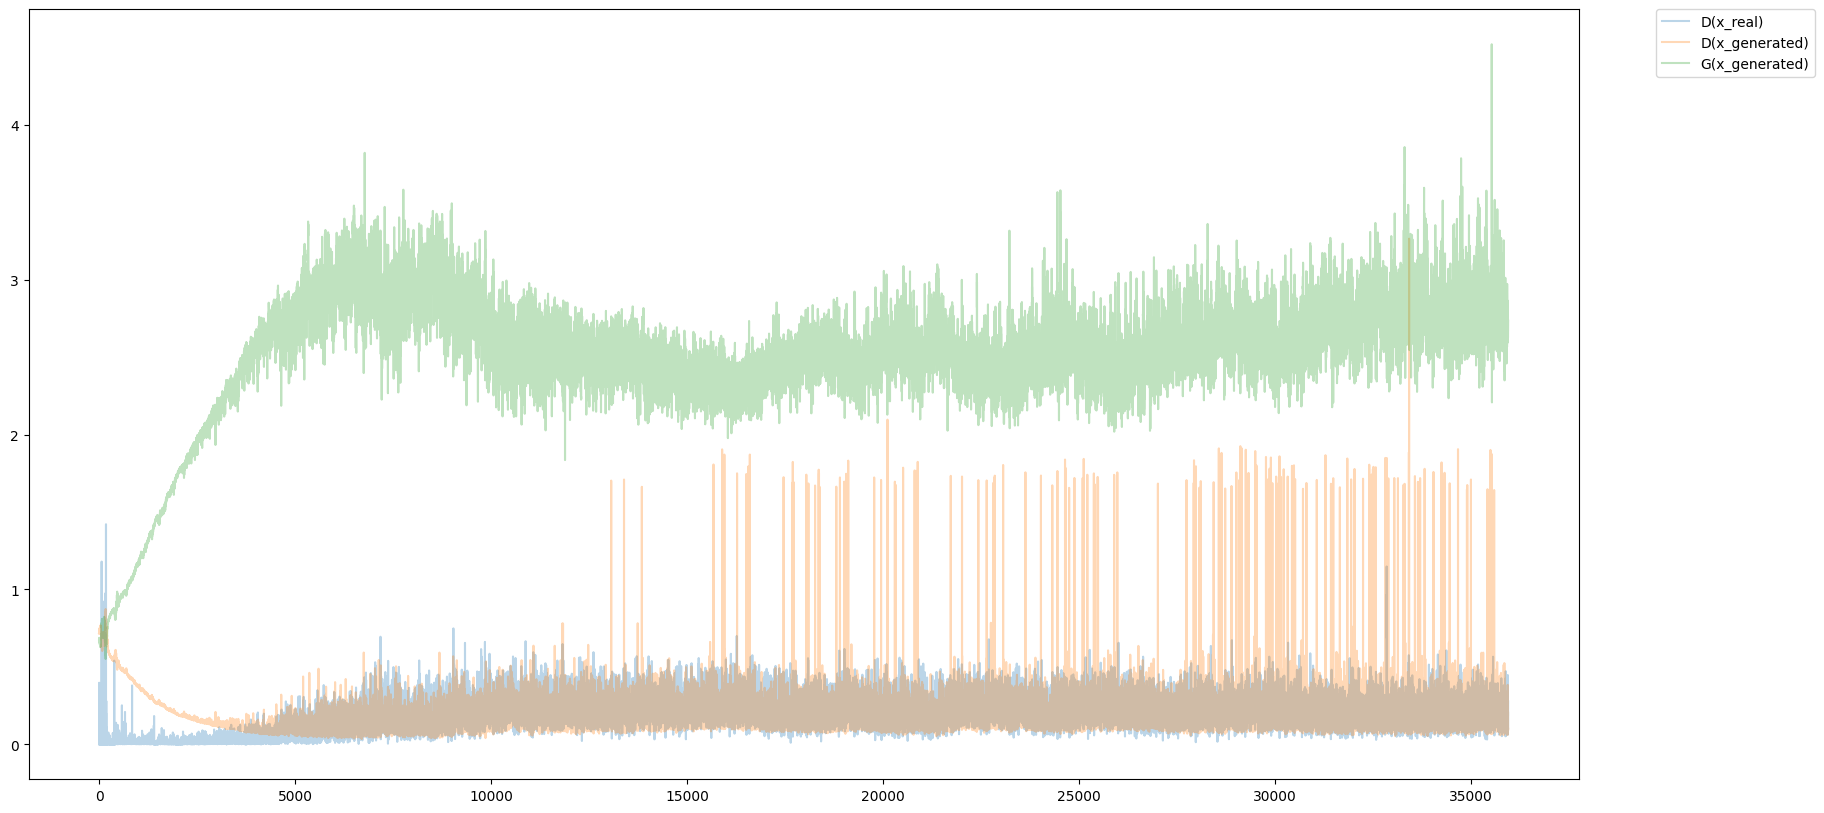

In [89]:
from matplotlib import pyplot as plt

sIdx = 50
plt.figure(figsize=(20,10))
plt.plot(p_d_real_trace[sIdx:], label='D(x_real)', alpha=0.3)
plt.plot(p_d_gen_trace[sIdx:], label='D(x_generated)', alpha=0.3)
plt.plot(p_g_gen_trace[sIdx:], label='G(x_generated)', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [90]:
n_samples = len(data_df)
gen_samples = generator(torch.randn(n_samples, latent_size))
gen_df = pd.DataFrame(gen_samples.detach(), columns=data_df.columns)
# display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
display('ori:',data_df.iloc[:,:15].describe(),'gen:',gen_df.iloc[:,:15].describe())

'ori:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000
mean,1.955990,165.157552,10.074219,635.361589,54.635320,461.637240,23.727350,193.037240,4.694709,147.285807,1.886218,212.825911,2.946457,394.695182,8.685835
std,1.010243,6.359456,1.892188,120.785230,32.478801,315.583742,26.478801,307.105759,9.658003,217.245590,5.403161,271.332683,9.837637,437.454045,20.391957
min,0.000000,155.000000,1.000000,22.000000,0.000000,77.000000,0.000000,4.000000,0.000000,6.000000,0.000000,22.000000,0.000000,6.000000,0.000000
25%,1.000000,160.000000,10.000000,563.000000,26.811371,80.000000,3.846154,77.000000,0.800000,77.000000,0.485968,97.000000,0.485879,120.000000,0.517241
50%,1.000000,160.000000,10.000000,591.000000,47.368421,563.000000,13.974287,80.000000,1.811595,94.000000,0.909091,114.000000,0.892857,176.000000,1.074114
75%,3.000000,170.000000,10.000000,681.000000,100.000000,612.000000,36.012906,92.000000,5.102041,114.000000,1.500000,179.000000,1.636663,370.000000,2.857143
max,3.000000,195.000000,30.000000,1410.000000,100.000000,1410.000000,100.000000,1410.000000,100.000000,1410.000000,100.000000,1410.000000,100.000000,1410.000000,100.000000


'gen:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000,7680.000000
mean,-33.513832,263.671753,-15.363115,828.982178,33.367733,725.923828,49.451401,248.191742,4.459227,224.246872,30.547810,208.230988,15.231508,504.053101,8.289247
std,26.858395,160.148590,27.233356,357.153076,58.442451,420.940948,71.454315,227.274933,34.451576,184.242615,37.149933,229.556580,47.231258,286.554260,50.439938
min,-140.843475,-49.946011,-131.517624,89.368088,-134.384521,-689.955872,-134.958893,12.170848,-127.287262,-222.874924,-96.955383,-681.090332,-144.505997,-163.860901,-175.589859
25%,-50.538293,139.364952,-32.491385,558.271622,-7.976017,439.578102,-2.786674,90.109276,-18.448860,88.098999,5.291402,60.786974,-17.039505,291.848503,-27.809620
50%,-32.390512,237.785942,-12.784418,782.506012,28.620811,720.708923,41.365974,142.617348,3.851264,202.994621,30.493639,211.457291,13.668881,466.870926,4.940490
75%,-15.112898,359.574631,3.771990,1051.425110,68.957806,996.180145,94.399010,352.974770,26.747612,340.493462,54.996493,362.220909,45.756906,678.541595,40.520673
max,54.735302,1016.939087,86.094147,2246.223145,251.305817,2671.470459,346.152161,1474.578247,144.134430,1056.787598,181.731461,1056.118652,261.609955,1847.518921,241.973923


In [85]:
batch_size = 64
lr = 0.005
num_epochs = 300
show_step = 25
loss_function = nn.BCELoss()

# 모델 인덱스
model_index = '1_1'

# 대상
yCols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

for yCol in yCols[1:2]:
    data_df = pd.read_csv(f'./dataset/data_{yCol}_jrcode_fin.csv')
    for i in range(1, 21):
        data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].apply(lambda x: int(JRCODE_dict[x]))
        # data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].where(data_df['jrcode'+str(i)] == len(JRCODE_dict), np.nan)
        data_df['phr'+str(i)].fillna(0, inplace=True)

    data_df['mix_ds_cd'] = data_df['mix_ds_cd'].apply(lambda x: int(MIXDSCD_dict[x]))
    # data_df['mix_ds_cd'] = data_df['mix_ds_cd'].where(data_df['mix_ds_cd'] == len(MIXDSCD_dict), np.nan)

    data_df = data_df.drop(['lab_pk', yCol], axis=1)
    data_df = data_df.iloc[:-(len(data_df) % batch_size)]

    # DataFrame을 PyTorch Tensor로 변환
    data = torch.tensor(data_df.values, dtype=torch.float32)

    # DataLoader 설정
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 모델, 옵티마이저, 손실 함수 설정
    input_size = len(data_df.columns)  # 입력 feature의 개수
    latent_size = 100  # 잠재 공간의 크기
    output_size = len(data_df.columns)  # 출력 feature의 개수
    discriminator = Discriminator(input_size)
    generator = Generator(latent_size, output_size)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)

    p_d_real_trace = []
    p_d_gen_trace = []
    p_g_gen_trace = []

    # 학습 시작
    stTime = time.time()
    for epoch in range(num_epochs):
        for n, (real_samples,) in enumerate(dataloader):
            # batch_size = real_samples.size(0)

            # Data for training the discriminator
            real_samples_labels = torch.ones((batch_size, 1))
            output_real = discriminator(real_samples)

            generated_samples = generator(torch.randn((batch_size, latent_size)))
            generated_samples_labels = torch.zeros((batch_size, 1))
            output_gen = discriminator(generated_samples)

            # Training the discriminator
            discriminator.zero_grad()
            loss_real = loss_function(output_real, real_samples_labels)
            loss_gen = loss_function(output_gen, generated_samples_labels)
            loss_discriminator = (loss_real + loss_gen) / 2
            loss_discriminator.backward()
            d_optimizer.step()

            # Data for training the generator
            latent_space_samples = torch.randn((batch_size, latent_size))

            # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            g_optimizer.step()

            p_d_real_trace.append(loss_real.item())
            p_d_gen_trace.append(loss_gen.item())
            p_g_gen_trace.append(loss_generator.item())

            # Show loss
            if epoch % show_step == 0 and n == batch_size - 1:
                print(f"Epoch: {epoch:3.0f} Loss D.: {loss_discriminator:.5f}, Loss G.: {loss_generator:.5f}, time: {(time.time() - stTime):.3f}s")
                stTime = time.time()


Epoch:   0 Loss D.: 0.34474, Loss G.: 0.73922, time: 0.311s
Epoch:  25 Loss D.: 0.32490, Loss G.: 1.55825, time: 13.256s
Epoch:  50 Loss D.: 0.61518, Loss G.: 1.09073, time: 13.672s
Epoch:  75 Loss D.: 0.46644, Loss G.: 1.10287, time: 13.109s
Epoch: 100 Loss D.: 0.59378, Loss G.: 0.83337, time: 12.931s
Epoch: 125 Loss D.: 0.65318, Loss G.: 0.83681, time: 13.560s
Epoch: 150 Loss D.: 0.66670, Loss G.: 0.73804, time: 13.850s
Epoch: 175 Loss D.: 0.67448, Loss G.: 0.72643, time: 13.582s
Epoch: 200 Loss D.: 0.66621, Loss G.: 0.76387, time: 13.104s
Epoch: 225 Loss D.: 0.69114, Loss G.: 0.70255, time: 13.066s
Epoch: 250 Loss D.: 0.69315, Loss G.: 0.69339, time: 13.081s
Epoch: 275 Loss D.: 0.69315, Loss G.: 0.69294, time: 12.546s


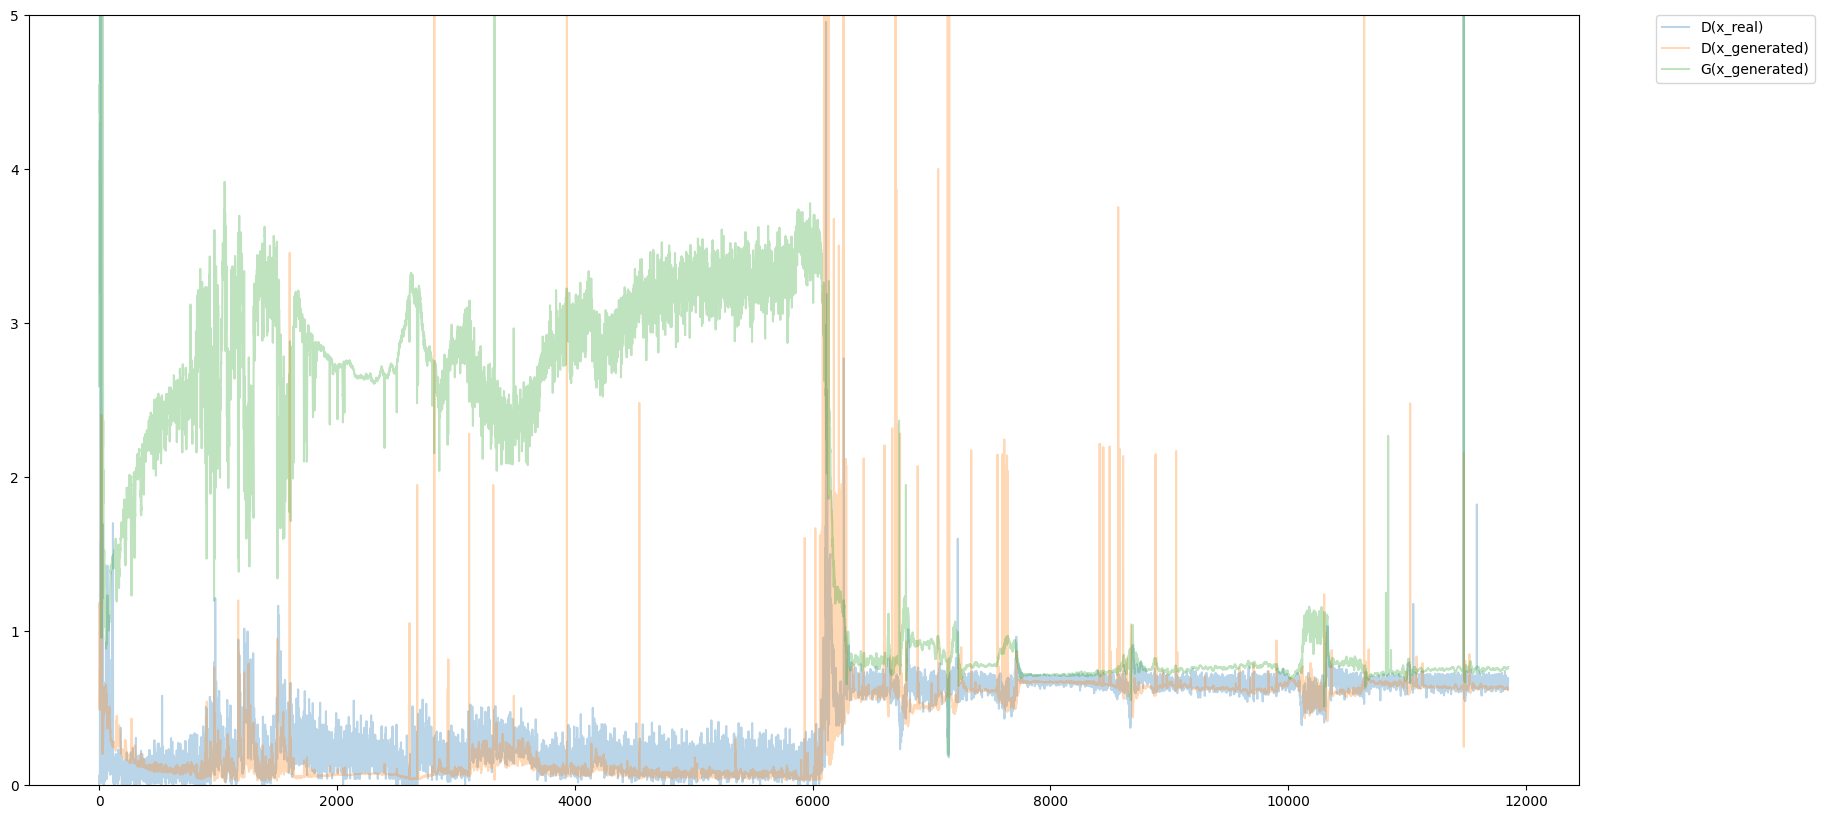

In [83]:
from matplotlib import pyplot as plt

sIdx = 50
plt.figure(figsize=(20,10))
plt.plot(p_d_real_trace[sIdx:], label='D(x_real)', alpha=0.3)
plt.plot(p_d_gen_trace[sIdx:], label='D(x_generated)', alpha=0.3)
plt.plot(p_g_gen_trace[sIdx:], label='G(x_generated)', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,5)

plt.show()

In [84]:
n_samples = len(data_df)
gen_samples = generator(torch.randn(n_samples, latent_size))
gen_df = pd.DataFrame(gen_samples.detach(), columns=data_df.columns)
# display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
display('ori:',data_df.iloc[:,:15].describe(),'gen:',gen_df.iloc[:,:15].describe())

'ori:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000
mean,1.954963,165.094538,10.068277,634.418986,54.764328,462.961922,23.691298,193.765362,4.733618,148.135636,1.904832,217.054753,3.092536,396.879858,8.657150
std,1.010097,6.291579,1.891700,120.544321,32.510340,316.049887,26.337707,308.356734,9.700926,220.578989,5.474049,278.490021,10.205194,439.620822,20.359143
min,0.000000,155.000000,1.000000,22.000000,0.000000,77.000000,0.000000,4.000000,0.000000,6.000000,0.000000,22.000000,0.000000,6.000000,0.000000
25%,1.000000,160.000000,10.000000,563.000000,26.921066,80.000000,3.898295,77.000000,0.802139,77.000000,0.487805,97.000000,0.486500,120.000000,0.517063
50%,1.000000,160.000000,10.000000,591.000000,47.368421,563.000000,14.056132,80.000000,1.847575,94.000000,0.909091,114.000000,0.898338,176.000000,1.079622
75%,3.000000,170.000000,10.000000,681.000000,100.000000,624.000000,36.087126,92.000000,5.102041,114.000000,1.500000,179.000000,1.666667,386.000000,2.857143
max,3.000000,195.000000,30.000000,1410.000000,100.000000,1410.000000,100.000000,1410.000000,100.000000,1410.000000,100.000000,1410.000000,100.000000,1410.000000,100.000000


'gen:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000
mean,-45.572987,78.743553,5.445159,204.947968,-66.628593,124.753410,9.749719,23.829094,15.621241,65.900291,40.287529,99.796501,103.148224,261.949982,-1.690291
std,22.613924,18.589699,19.758615,40.795967,10.745924,14.924346,13.513802,10.809854,13.382223,48.619396,26.204762,53.504498,19.920038,90.750664,30.249865
min,-80.026474,43.271378,-99.298370,-4.442436,-96.101166,67.314156,-10.675160,-28.967466,-17.885143,-221.884888,-43.010712,-205.867508,63.509861,-242.672775,-42.150368
25%,-62.790256,65.090536,-4.504930,185.144226,-73.987957,115.139698,0.326549,18.145824,6.767510,45.484569,24.710485,76.593613,88.329056,224.629028,-24.680348
50%,-52.160038,74.595356,11.407514,215.644135,-68.502190,124.574673,4.858130,26.583184,12.032924,83.735378,36.117744,118.625809,99.511662,296.635590,-11.574251
75%,-34.629266,88.584517,20.514513,233.483295,-60.990296,134.384220,14.622308,31.969606,21.445261,101.042610,53.977282,138.037777,114.734112,323.103058,12.993156
max,76.882729,180.683792,35.807369,295.600586,-9.753685,192.910950,88.604248,41.777222,88.859688,130.919449,180.508026,185.070389,203.924088,421.247284,164.035095
